## Import Common Package

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import Data

In [2]:
df = pd.read_csv("carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


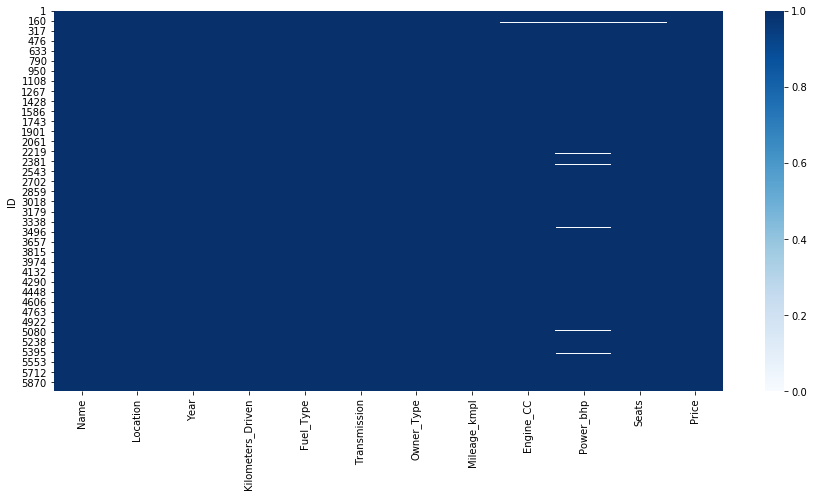

In [7]:
plt.figure(figsize=(15,7))
sns.heatmap(-df.isnull(), cmap='Blues')

In [8]:
df=df.drop(columns='Name')

## Dataset Splitting

In [9]:
X = df.drop(columns="Price")
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

## Training

In [12]:
X_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats
ID,,,,,,,,,,
4380,Coimbatore,2016,60913,Petrol,Manual,First,20.73,1373.0,91.1,5.0
2676,Kochi,2017,40459,Diesel,Manual,First,19.67,1582.0,126.2,5.0
647,Jaipur,2004,200000,Petrol,Manual,First,0.00,1086.0,NaN,5.0
5966,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.1,5.0
2198,Ahmedabad,2013,96000,Diesel,Manual,Second,23.50,1498.0,90.0,5.0


In [13]:
df.describe()

,Year,Kilometers_Driven,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
count,5953.000000,5.953000e+03,5951.000000,5917.000000,5811.000000,5911.000000,5953.000000
mean,2013.356459,5.876729e+04,18.064325,1627.298293,113.803144,5.281509,9.547306
std,3.275069,9.174384e+04,4.511393,601.584633,53.896719,0.810628,11.230163
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.100000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.120000,1495.000000,98.600000,5.000000,5.700000
75%,2016.000000,7.300000e+04,21.025000,1991.000000,139.010000,5.000000,10.000000
max,2019.000000,6.500000e+06,28.400000,5998.000000,560.000000,10.000000,160.000000


In [14]:
df.columns

Index(['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Seats',
       'Price'],
      dtype='object')

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Year', 'Kilometers_Driven', 'Mileage_kmpl',  'Engine_CC', 'Power_bhp',  'Seats' ]),
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type' ]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])




model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   31.7s finished
C:\Users\93kry\.conda\envs\jcopml\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.4191924234077009 0.08719101680389418 0.055845667362476537


## Scaling can Help KNN & SVM

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Year', 'Kilometers_Driven', 'Mileage_kmpl',  'Engine_CC', 'Power_bhp',  'Seats' ]),
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type' ]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])




model = GridSearchCV(pipeline, gsp.svm_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   15.5s finished
C:\Users\93kry\.conda\envs\jcopml\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8692907569381978 0.836494284747232 0.8314246832596819


## Polynomial Features

In [19]:
gsp.svm_prep_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [20]:
gsp.svm_poly_params

{'poly__degree': [1, 2, 3],
 'poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='robust'), ['Year', 'Kilometers_Driven', 'Mileage_kmpl',  'Engine_CC', 'Power_bhp',  'Seats' ]),
    ('categoric', cat_pipe(encoder='onehot'), ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type' ]),
])



pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])




model = GridSearchCV(pipeline, gsp.svm_prep_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:  3.0min finished
C:\Users\93kry\.conda\envs\jcopml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\93kry\.conda\envs\jcopml\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8692907569381978 0.836494284747232 0.8314246832596819


## Save Model

In [22]:
save_model(model.best_estimator_, "car_price.pkl")

Model is pickled as model/car_price.pkl
